<H1>Numerisk løsning av den tidsuavhengig Schrödingerligningen</H1>

<p>Notatboken og tilhørende kildekode ligger på <a href="https://github.com/kaprests/Numerical-1D-TISE">GitHub.</a></p>

<H2>Gruppe 21: Henrik E. V. Skaldebø og Knut Andre G. Prestsveen</H2>

<H2>Sammendrag</H2>
Denne notatboken prosjekt nummer to i faget TMA4320, og øving i faget TFY4215 ved Norges tekniske og naturvitenskapelige universitet. Den undersøker enkle, endimensjonale, kvantemekaniske modeller for atomer, molekyler og krystaller med ikke-vekselvirkende elektroner, og finner stasjonære løsninger av den tidsuavhengige schrödingerligninen (TUSL) for hver av modellene.

<H2>Introduksjon</H2>
Omkring alle atomer, er det et potensiale som elektronene befinner seg i, og dette potensialet modelleres med én endelig potensialbrønn med bredde $\omega$ og dybde $V_0$, omgitt av potensialet $V = 0$. Molekyler og krystaller modelleres ved å sette sammen flere enkeltbrønner, sepparert av små barrierer med bredde $\omega/5$ med potensialet $V = 0$. Mer presist er brønnpotensialet

$$
V = \begin{cases}
        V_0 & \text{, $\mid x \mid \leq \omega/2$}\\
        0 & \text{, ellers}
    \end{cases}
$$

for en brønn sentrert om $x = 0$.

<h3>Numerisk løsning av (1D) TUSL</h3>
TUSL i en dimensjon er

$$
- \frac{\hbar^2}{2m} \frac{d^2\psi(x)}{dx^2} + V(x)\psi(x) = E\psi(x).
$$

De stasjonære løsningene innholder energiegenfunksjonene, som sammen med tilhørende egenverdier løser TUSL, og for hvert energinivå er det plass til to elektroner, ett med spinn opp og ett med spinn ned, i følge Pauliprinsippet.

Med unntak av hydrogenatomet har en dog ikke analytiske løsninger av TUSL, og det benyttes derfor her en numeriske løsningsmetode. For å forenkle probleme yttligere taes det utgangspunkt i bokspotensialet utgangspunkt i bokspotensialet, altså at partikkelen kun kan oppholde seg på et endelig område langs x-aksen, avgrenset av harde vegger (uendelig potensiale) i endepunktene $x=0$ og $x=L$. Partikkelens posisjon på dette området diskretiseres i $N$ mulige verdier, slik at løsningene går fra $\psi(x)$ til $\psi(n\Delta x)$, hvor $n = 0, 1, 2, ... , N, N+1$. I endepunktene er bølgefunskjonen null på grunn av kontinuitet i overgangen ved veggene, siden bølgefunksjonen må være null der potensialet er uendelig. Med diskret posisjon og operatorer kan TUSL da skrives som de $N$ differanseligningene

$$
- \frac{\hbar^2}{2m} \frac{\psi_{n+1}-2\psi_n+\psi_{n-1}}{(\Delta x)^2} + V_n\psi_n = E\psi_n.
$$

Som igjen kan skrives på matriseform

$$
\mathbf{H}\vec{\psi} = E\vec{\psi},
$$

hvor $\mathbf{H}$ er en $NxN$ matrise med diagonalelementer 

$$H_{nn} = \frac{\hbar^2}{m(\Delta x)^2} + V_n, \quad n = 1, 2, 3,..., N,$$

elementer over og under diagonalen

$$H_{n, n\pm1} = - \frac{\hbar^2}{2m(\Delta x)^2} \quad n = 1, 2, 3,..., N, $$

og $E$ er energi-/egenverdier. Denne egenverdiligningen har ikke-trivielle løsninger kun når $\text{det}(\mathbf{H}-E)=0$, hvor $I$ er identitetsmatrisen. $E\mathbf{I}$ er da en $NxN$ matrise med energiverdiene langs diagonalen, og poenget er at de numeriske løsningene for bølgefunksjonene og energinivåene er gitt av hhv. egenvektorene og egenverdiene til $\mathbf{H}$-matrisen.





In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
from scipy.constants import hbar, m_e, eV
from scipy.linalg import eigh_tridiagonal

hbar *=1e9 #Plancks constant, scaled for nm as recomended by mr. MAN ;)
L_well = 0.5 #nm - length/width of each potential well
V0 = 10 #eV - depth of the wells
n_well = 20 # number of datapoints per well
n_bar = 4 # number of datapoints per barrer -> barrier width = 0.5/5 nm
fact = (hbar**2)/(m_e*eV) # precalculated factor to lessen float operations


# Constructs a potential with num_w number of wells
def potential(num_w, V0=-V0):
    V1 = np.array([[V0]*n_well + [0]*n_bar]).flatten() # one well with barrier to the right
    V_mid = np.tile(V1, num_w) 
    V_front = np.zeros(n_well*10)
    V_back = np.zeros(n_well*10 - n_bar)
    V = np.append(V_front, V_mid)
    V = np.append(V, V_back)
    well_voids = max(num_w -1, 0)
    L = num_w*L_well + well_voids*n_bar*(L_well/n_well) + 20*L_well
    return V, L # returns the final potential and length of the system


# Calculates eigenenergies and eigenvector(wave functions)
def analyze(num_w, add_E_lvls = 0):
	V, L = potential(num_w)
	n = len(V)
	delta_x = L/(n+1)
	x_vec = np.linspace(0, L, n)
	if num_w == 0:
		num_E_lvls = 3 + add_E_lvls
	else:
		num_E_lvls = 3*num_w + add_E_lvls
	
	main_diag = np.ones(n) * fact/(delta_x**2) + V
	off_diag = np.ones(n-1) * -fact/(2*delta_x**2)

	energies, wave_funcs = eigh_tridiagonal(main_diag, off_diag)
	wave_funcs = wave_funcs.T

	return energies, wave_funcs, x_vec, num_E_lvls, L, V


def plot_well_wave_funcs(num_w, add_E_lvls=0, start_E_lvl=0, end_E_lvl=0):
    energies, wave_funcs, x_vec, n_E_lvls, L, V = analyze(num_w, add_E_lvls)
    if end_E_lvl == 0:
        end_E_lvl = n_E_lvls
    scale = V0
    if num_w == 0:
        scale = 1
    for i in range(start_E_lvl, end_E_lvl):
        plt.plot([0,L], [energies[i]]*2)
        plt.plot(x_vec, V)
        plt.plot(x_vec, energies[i] + wave_funcs[i]*scale)
    #plt.savefig("figW" + str(num_w) + "E" + str(iter_lim) + ".pdf")
    plt.show()
    
# Code for task 4.
# Computes and plots bandwiths of the three bound energy levels for num. of wells from lower to upper.
def band_widths(lower, upper):
	x_vec = np.linspace(lower, upper, upper-lower)
	band_widths = np.zeros([3, upper - lower])
	for i in range(lower, upper):
		energies,_,_,_,_,_ = analyze(i)
		for j in range(3):
			band_widths[j][i - lower] = np.absolute(energies[i*j] - energies[(j+1)*i -1])

	for i in range(3):
		plt.plot(x_vec, band_widths[i])
	#plt.savefig("bw.pdf")
	plt.show()

### Oppgave 1 - Partikkel i boks
    
For å teste algoritmen, undersøkes først en uendelig dyp potensialbrønn med potensial $V(x)=0$ for $0<x<L$. Også betegnet som en partikkel i boks, hvor potensialet er uendelig utenfor og 0 innenfor boksen. Den tidsuavhengige schrödingerligningen har følgende analytiske funksjoner for en slik potensialbrønn

$$\psi_j (x) = \sqrt{2/L}\sin k_jx$$

med egenenerginivå

$$E_j = \frac{\hbar^2 k_j^2}{2m}$$

Både $\psi_j$ og $E_j$ bruker bølgetallene $k_j$, med $j = 1, 2, 3...$

$$k_j = \frac{j \pi}{L}$$

Koden i den følgende cellen beregner disse analytiske løsningene, plotter og lagrer dem i en pdf.

In [3]:
#analytisk løsning

L = 10 #nm
n = 100
k_j = np.pi/L
energy_factor = (hbar**2)/(2*m_e)
x = np.linspace(0, L, n)
scale = 0.01 #for å skalere bølgefunksjonene

def wave_func(j, x):
    return np.sqrt(2/L)*np.sin(k_j*j*x)

def plot_analytic(levels):
    for j in range(1, levels+1):
        energy = energy_factor*((k_j*j)**2)/eV
        plt.plot([0, L], [energy]*2)
        plt.plot([0, L], [0]*2) #potensialnivået ved V=0
        plt.plot(x, energy + wave_func(j, x)*scale)
    plt.xlabel("Width (nm)")
    plt.ylabel("Energy (eV)")
    plt.title("Analytical - Wells: 0, Energy-levels: " + str(levels))
    #plt.savefig("analyticW0E" + str(levels) + ".pdf")
    plt.show()

Figuren nedenfor viser de analytiske løsningene, funnet ved <font color=blue>plot_analytic()</font> for tre nivå, samt de numeriske, ved <font color=blue>plot_well_wave_funcs()</font> for ingen brønner. Amplituden for de analytiske bølgefunksjonene er vanligvis $\sqrt{2/L}$, men er her skalert ned for å samsvare bedre med de numeriske løsningene. Energinivåene fra de numeriske løsningene stemmer her meget bra med det analytiske resultatet. Ved å se på bølgefunksjonene som korresponderer med hvert energinivå stemmer også dette ettersom kurvene har samme antall ekstremalpunkt Grunnen til at vi ved tredje energinivå får forskjellig antall maksima/minima kommer av at scipy-funksjonen <font color=blue>eigh_tridiagonal()</font> ikke nødvendigvis ser forskjell på de to tilfellene(blir det riktig å si?? :o ).

![title](oppg1comparison.png)

Det finnes kun en egenfunksjon for hver egenenergiverdi som tilsier at funksjonene er ortogonale. Dette kommer også av at vi kun ser på endimensjonale situasjoner som betyr at energiegenverdiene ikke kan være degenererte, det vil si at flere egenfunksjoner svarer til én egenverdi.

For at bølgefunksjonene skal være normerte må de oppfylle
$$
\sum_{n=1}^{N} |{\psi^{(j)}}|^2 = 1 \quad ; \quad j = 1, 2, ..., N.
$$

I skriptet under hentes bølgefunksjonene ved <font color=blue>analyze()</font>, summerer hver egenfunksjon i henhold til uttrykket over og printer den største samt den minste summen. Her kommer det dermed frem at alle verdiene ligger svært nærme 1 som tilsier at funksjonene våre er normerte. 

In [4]:
_, w_f, _, _, _, _ = analyze(3) #henter ut bølgefunksjonene

w_f = np.absolute(w_f)**2 #opphøyer alle elementene i matrisen med

w_f_sum = np.sum(w_f, axis=1) #summerer alle elementene i hver bølgefunksjon

print(np.max(w_f_sum))
print(np.min(w_f_sum))

1.0000000000000018
0.9999999999999983


### Oppgave 2 - Atomer

Nå ser vi på modeller som inneholder potensiallbrønner og kan beskrive atomer, molekyler og krystaller. Funksjonene vi bruker for å beregne og plotte energinivå med tilsvarende bølgefunksjoner har en input-parameter for antall potensialbrønner det skal ses på. Forrige oppgave så vi kun på et enkelt potensial lik 0, mens fra nå av vil vi undersøke bokspotensialet med endelige potensialbrønner som har negativt potensial. Funksjonene er også definert slik at ved inklusjon av brønner vil det være et område lik 10 brønnbredder på begge sider av brønnen slik at det er god avstand til de harde veggene. Ved tilfeller av flere brønner vil det legges til en liten barriere mellom brønnene.

Én brønn vil kunne kvalitativt vise hvordan elektronene oppfører seg i et enkeltatom, med både diskrete bundne tilstander og et kontinuerlig spektrum av frie elektroner.  

a)<br/>
Det endelige brønnpotensialet er på forhånd definert, V_0=-10 eV, slik at vi får tre bundne tilstander. Ved det klassisk tillate området, dvs E>V(x), som i dette tilfellet blir inne i brønnen, noterer vi oss oppførselen til bølgene. For annenhvert energinivå skal bølgefunksjonene være symmetriske og antisymmetriske. I figuren vist nedenfor kan en se at grunntilstanden er symmetrisk, andre tilstand antisymmetrisk og tredje symmetrisk igjen, Nice ;)!

I det klassiske tillate området vil bølgefunksjonene tilnærmet følge den analytiske løsningen

$$\psi_j (x) = \sqrt{2/L}\sin k_jx$$

med bølgetallene

$$k_j  = \frac{j \pi}{L} = \frac{2\pi}{\lambda}, \quad j = 1, 2, 3...$$

bølgelengden vil dermed kunne skrives som 

$$ \lambda = \frac{2}{j}L .$$.

Dette betyr at i det klassisk tillate området er bølgelengden omvendt proporsjonalt med kvantetallet $j$. I de tre bundne tilstandende våre kan en dermed observere at bølgelengdene for hvert energinivå tilsvarer omtrent $2L$, $L$ og $\frac{2}{3} L$.

En siste egenskap verdt å nevne er krumningen til bølgefunksjonene i det klassiske tillate området. Utifra Schrödingers tidsuavhengige ligning har vi

$$
- \frac{\hbar^2}{2m} \frac{\partial^2 \psi(x)}{\partial x^2} = [E-V(x)]\psi(x) 
$$

$$\text{dvs.}$$

$$ 
\frac{d^2\psi/dx^2}{\psi} = \frac{2m}{\hbar^2}[V(x)-E],
$$

Krumningen $d^2\psi/dx^2$, for E>V(x), vil være negativ når $\psi$ er positiv, og omvendt. Det betyr at den relative krumningen $\psi''/\psi$ alltid er negativ og bølgen vil alltid krumme mot x-aksen. Ved klassiske forbudte områder vil det motsatte være tilfelle som gir oss bildet vi ser på de numeriske plottede bølgene under. Innenfor brønnen krummer bølgene seg mot aksen, i vårt tilfelle mot energinivået ettersom egenfunksjonene er skalert etter dem, og utenfor brønnen krummer bølgene seg vekk fra aksen og nærmer seg fort null. Dette tyder på det er meget lite sannsynlighet for at elektronet oppholder seg i det klassiske forbudte området langt unna brønnen, men det er fortsatt en viss sannsynlighet for at den kan oppholde seg i umiddelbar nærhet av brønnveggen. 

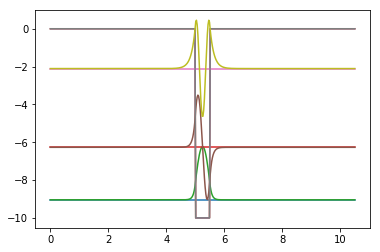

In [5]:
plot_well_wave_funcs(1)

For å finne analytiske beregnede energinivåer for potensialet med en brønn brukes den transcendentale funksjonen beskrevet i Griffiths

$$
\tan{z} = \sqrt{(z_0/z)^2 - 1}
$$

$z$ er her en funksjon av energien $E$ gitt av

$$
z = \frac{\sqrt{2m(E+V_0}}{\hbar}a,
$$

hvor $a$ er halvparten av brønnbredden. $z_0$ er et mål på størrelsen av brønnen og er gitt som 

$$
z_0 = \frac{a}{\hbar} \sqrt{2 m V_0}.
$$

For å beregne energinivåene analytisk brukes følgende plott:

Energi #1:  -9.038957100851231
Energi #2:  -6.244717176021442
Energi #3:  -2.049505532565955
Num energies:  -9.043560659888897
Num energies:  -6.268381845422539
Num energies:  -2.104781711697484


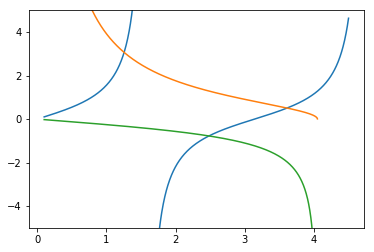

In [6]:
# Numerically computes the energies from the analytic solutions of TISE and prints them
def trancendent_sol():
	a = L_well/2
	
	z0 = (a/hbar)*np.sqrt(2*m_e*V0*eV)
	
	RS = lambda z : np.sqrt((z0/z)**2 -1)
	RS_asym = lambda z : -1/(np.sqrt((z0/z)**2 -1))
	LS = lambda z : np.tan(z)

	z_tan = np.linspace(0.1,4.5, 1000)
	z = np.linspace(0.1,4.05, 1000)
	for i in range(len(z_tan)):
		if np.absolute(LS(z_tan[i])) > 9:
			z_tan[i] = np.nan

	f = lambda z : RS(z) - LS(z)
	f_asym = lambda z : RS_asym(z) - LS(z)
	
	z_zeros = np.array([1.2, 3.5])
	z_zeros = fsolve(f, z_zeros)

	z_zeros_asym = 2
	z_zeros_asym = fsolve(f_asym, z_zeros_asym)
	
	z_zeros = np.array([z_zeros[0], z_zeros_asym[0], z_zeros[1]])

	E = lambda z : ((z*hbar)**2)/((a**2)*2*m_e*eV) - V0 # Okay, still not perf. div by a**2 arbitrarily to get the energies to match, but someone should figure this out later.
	for i in range(len(z_zeros)):
		print("Energi #" + str(i+1) + ": ", E(z_zeros[i]))

	energies,_,_,_,_,_ = analyze(1)
	for i in range(3):
		print("Num energies: ", energies[i])

	plt.ylim(-5, 5)
	plt.plot(z_tan, LS(z_tan))
	plt.plot(z, RS(z))
	plt.plot(z, RS_asym(z))
	#plt.savefig("trancend_plot.pdf")
	plt.show()
	
	#return z_zeros
    
trancendent_sol()

Skjæringspunktene mellom $\tan{z}$ (de blå linjene) og $\sqrt{(z_0/z)^2 - 1}$ viser for hvilke $z$ det eksisterer et energinivå som dermed kan løses for $E$. Skriptet over printer også ut både de analytiske og numeriske egenenergiverdiene som stemmer meget bra.

Ved å legge til flere energinivå i den siste input-parameteren til <font color=blue>plot_well_wave_funcs()</font> kan de ubundne tilstandene undersøkes. 


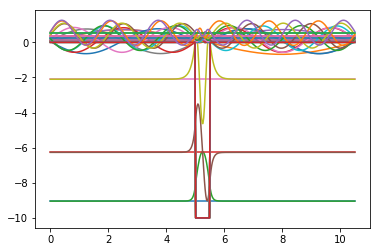

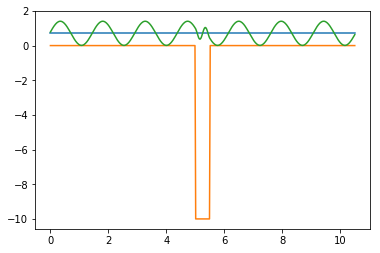

In [7]:
plot_well_wave_funcs(1, 12)
plot_well_wave_funcs(1, 12, 15, 16)

Det første plottet viser 12 ekstra energinivå som danner et "kvasikontinuerlig" spektrum av ubundne tilstander for $E>0$. I det neste plottet ser vi kun på den øverste av disse energinivåene. Ved inspeksjon kommer det frem at bølgelengden er mindre innenfor brønnområdet enn utenfor. Impulsen til elektronet kan ved de Broglie-bølgelengden skrives som
$$
p = \frac{2 \pi \hbar}{\lambda},
$$

og dette viser at elektronets kinetiske energi burde være lavere innenfor brønnen enn utenfor. Dette samsvarer med at elektronets kinetiske energi er lavere ved negativ potensiell energi.

b)

For tre bundne tilstander vil det være mulig å fylle orbitalene med opptil seks elektroner som betyr at atom med atomnummer 1 til 6 er aktuelle med tre bundne tilstander. I grunntilstanden til hvert atom med partall antall elektroner, slik som helium og karbon, vil elektronspinnet til atomet være null. Ved odde antall elektroner, som i hydrogen og lithium, blir elektronspinnet $S = \frac{\sqrt{3}}{2}\hbar$.



<h2>Oppgave 3 - Molekyler</h2>




Som det ble nevnt innledningsvis, modellerer vi potensialet for molekyler ved å sette sammen flere endelige enkeltbrønner inne i et bokspotensial, vi ser her på homonukleære, toatomige molekyler, og som for atommodellen er det et $10\omega$ bredt område med nullpotensiale på hver side av brønnene. Bredde og dybde for brønnene, samt barrierebredden, er også som før.

Under plottes potensialene med både en og to brønner, med tilhørende energinivåer og bølgefunksjoner.

In [ ]:
# Plots wave functions and possible energy levels for one and two wells
plot_well_wave_funcs(2)
plot_well_wave_funcs(1)

Bindingsenergien er differansen mellom elektronenes energi i et molekyl og i frie enkeltatomer. For helium forventer vi en negativ bindingsenergi, siden helium naturlig forekommer som $H_2$ molekyler, og "ønsker" å binde seg. Grunnen til dette er at en for toatomige molekyler får to energinivåer per bundne tilstand, et med litt lavere og et med litt høyere energi enn grunnenergien for enkeltatomet. Disse to nivåene kalles henholdsvis bindende og antibindene orbitaler, og siden det i henhold til Paulis ekslusjonsprinsipp er plass til to elektroner per tilstand med en gitt energi, har $H_2$-molekyler begge sine elektroner i den bindende oribitalen, altså i lavere energitilstand enn enkle $H$-atomer.

Helium derimot forventes å ha en positiv bindingsenergi, siden det er en edelgass og ikke har lett for å danne bindinger med andre atomer. $He_2$-molekyler har fire elektroner fordelt på laveste bindende og antibindende orbital, og siden differansen mellom grunnenergien til atomet og antibindende orbital er større enn til bindende orbital, vil $He_2$-molekyler ha høyrere energi enn frie $He$ atomer.

Koden i cellen under regner ut bindingsenergiene for modellene våre for $H_2$ og $He_2$. Resultatet viser at vi får negative verdier for begge bindingsenergiene, og vi ser at bindingsenergien for helium er høyere enn for hydrogen, men den er fremdeles negativ. Det antyder at helium naturlig vil binde seg i molekyler, uten energitilførsel, som strider med ovenevnt teori, og det tyder på at modellen vår trolig ikke er presis nok og at energinivåene ikke plasseres helt korrekt.

In [ ]:
# Calculates and prints the binding energy of H2 and He2

# H2
energies_H2_well,_,_,_,_,_ = analyze(4)
energies_H_well,_,_,_,_,_ = analyze(2)
bind_energy_H2 = (2*energies_H2_well[0] - 2*energies_H_well[0])

# He2
energies_He2_well,_,_,_,_,_ = analyze(2)
energies_He_well,_,_,_,_,_ = analyze(1)
bind_energy_He2 = (2*energies_He2_well[0] + 2*energies_He2_well[1] - 4*energies_He_well[0])

print("Energi H2: ", energies_H2_well[0])
print("Energi 2H: ", energies_H_well[0])
print("Bindingsenergi: ", bind_energy_H2)
print("")
print("Energi He2: ", energies_He2_well[0])
print("Energi 2He: ", energies_He_well[0])
print("Bindingsenergi: ", bind_energy_He2)

<h2>Oppgave 4 - Krystaller</h2>



På samme måte som vi modelerte toatomige molekyler ved å sette sammen to potensialbrønner, kan vi kvalitativt modellere krystaller ved å sette sammen et stort antall brønner. Vi betegner antall brønner med $w_{\omega}$, og størrelsen på brønnene, barrierene og området rundt er det samme som før.

Med to brønner observerte vi at det ble to bundne tilstander for hvert enkelt atom. Vi tester med litt ulike verdier av $N_{\omega}$, og i alle tilfellene er antall tilstander for hver av de tre bundne tilstandene i enkeltatomet lik antall brønner. Nedenfor plottes det med fem og ti brønner.

In [ ]:
plot_well_wave_funcs(5)
plot_well_wave_funcs(10)

Vi ser at båndbredden til energiene også øker med antall brønner, men at tilstandene ligger vesentlig tettere med ti brønner enn med fem. Det tyder på at båndbredden vokser med avtakende hastighet, og at den mulig vil konvergere mot en fast verdi for store $N_{\omega}$

Nedenfor plottes det for et utvalg $N_{\omega}$, og under plottes båndbredden som funksjon av antall brønner, hvor $N_{\omega}$ går fra og med to til hundre.

In [ ]:
plot_well_wave_funcs(20)
plot_well_wave_funcs(50)
plot_well_wave_funcs(75)
band_widths(2,50)

Vi ser av plottene at energinivåene etter hvert for stort nok antall brønner ligger helt tett samlet, og det siste plottet viser at bredden på brønbreddene tydelig konvergerer. Det vil si at en for store $N_{\omega}$ får tilnærmet kontinuerlige energibånd omkring de tre bundne tilstandene for et atom.

Videre ser vi på en krystall modellert med 50 brønner, og vi anter at hvert atom har fire elektroner hver. Det vil si at krystallen har $4*N_{\omega}$ elektroner totalt, som opptar de $2*N_{\omega}$ (pauliprinsippet) tilstandene med lavest energi ved tilstrekkelig lav temperatur. Dette tilsvarer at de to nederste båndene er helt fylt, og energien til de to elektronene med høyest energi tilsvarer den høyeste energien i det andre båndet. Avstanden mellom denne energien og neste tilgjengelige enerinivå er derfor avstanden mellom energibånd to og tre, altså krystallens båndgap.

Nedenfor finner vi energien til de øverste elektronene for krystallmodellen vår, samt båndgapet.

In [ ]:
energies_crstl, wave_funcs_crstl, x_vec,_,_,_ = analyze(50)
print("Energien til øverste elektron: ", energies_crstl[99]) 
print("Båndgap: ", energies_crstl[100] - energies_crstl[99])


Kjører vi koden i cellen over ser vi at båndgapet er på ca. $2.6 eV$, som betyr at denne krystallen er en halvleder (båndgap større enn null, men mindre enn ca. 2 til 3 eV).\cite{STÆVNERN}

### Blochs teorem

(...)

Når vi skal se om bølge funksjonen følger Blochs teorem er det upraktisk med så mange som 50 brønner, og vi ser derfor nå heller på en modell med 10 brønner.

In [ ]:
plot_well_wave_funcs(10, 0, 0, 3)

Brønnpotensialet har en periodisitet lik brønnbredden pluss barrierebredden, $\omega + \omega/5 = 0.6 nm$.1